In [1]:
from functools import partial
import glob
import os
from typing import Callable, Optional, Sequence, Type

import equinox as eqx
from equinox import nn
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jaxtyping import Array, PRNGKeyArray
import optax

jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0.05)

from environment_base.util import load_compressed_pickle
from craftax.craftax_state import EnvState
from craftax.renderer import render_craftax_pixels
from craftax.constants import BLOCK_PIXEL_SIZE_AGENT, BLOCK_PIXEL_SIZE_IMG

%matplotlib inline

Processing textures
Textures saved to cache


In [ ]:
run_paths = sorted(glob.glob(os.path.join('data/', '*.pbz2')))
run = load_compressed_pickle(run_paths[-1])

In [3]:
print(run.keys())
for k, v in run.items():
    print(f'{k}: {v.shape if isinstance(v, np.ndarray) else len(v)}')

dict_keys(['state', 'action', 'reward', 'done'])
state: 3645
action: 3644
reward: 3644
done: 3644


In [4]:
all_imgs = [render_craftax_pixels(state, BLOCK_PIXEL_SIZE_AGENT) for state in run['state']]
all_imgs = jnp.stack(all_imgs) / 255.0

all_actions = jnp.stack(run['action'])
all_rewards = jnp.stack(run['reward'])
all_dones = jnp.stack(run['done'])

(91, 77, 3)


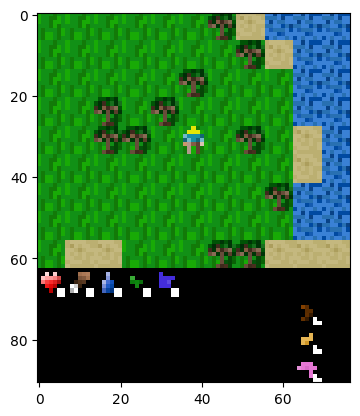

In [5]:
print(all_imgs[0].shape)
plt.imshow(all_imgs[0])
plt.show()

In [6]:
# TODO:
#   1. Create a function that trains the model to predict the next state with a variable batch size
#       - Make an MLP model
#       - Make an RMSProp optimizer
#       - Create a training loop
#   2. Test wth a few different batch sizes and step-sizes
#   3. Try simple MLP, CNN, and Streaming MLP
#   4. Try sweeping through layer dimensions and learning rates

In [60]:
def make_mlp_layers(
    layer_sizes: Sequence[int],
    activation_cls: Optional[Type[eqx.Module]] = None,
    *,
    key: Optional[PRNGKeyArray] = None
) -> Array:
    layers = []
    if key is not None:
        keys = jax.random.split(key, len(layer_sizes) - 1)
    else:
        keys = [None] * (len(layer_sizes) - 1)
    
    for i in range(1, len(layer_sizes)):
        layers.append(
            nn.Linear(layer_sizes[i - 1], layer_sizes[i], use_bias=False, key=keys[i-1]))
        if i < len(layer_sizes) - 1 and activation_cls is not None:
            layers.append(activation_cls())
    return layers


class ReLU(eqx.Module):
    def __call__(self, x: Array, *, key: Optional[PRNGKeyArray] = None) -> Array:
        return jax.nn.relu(x)


class ReshapeLayer(eqx.Module):
    shape: int | Sequence[int] = eqx.field(static=True)

    def __call__(self, x: Array, *, key: Optional[PRNGKeyArray] = None) -> Array:
        return x.reshape(self.shape)


class MLP(eqx.Module):
    layers: list[eqx.Module]

    def __init__(
        self,
        layer_sizes: Sequence[int],
        activation_cls: Optional[Type[eqx.Module]] = None,
        *,
        key: Optional[PRNGKeyArray] = None,
    ):
        self.layers = nn.Sequential(make_mlp_layers(layer_sizes, activation_cls, key=key))

    def __call__(self, x: Array, *, key: Optional[PRNGKeyArray] = None) -> Array:
        return self.layers(x, key=key)


class ConvAutoencoder(eqx.Module):
    encoder: nn.Sequential
    decoder: nn.Sequential

    def __init__(
        self,
        input_shape: Sequence[int],
        channel_sizes: Sequence[int], # Not including input channel size
        kernel_sizes: Sequence[int],
        strides: Sequence[int],
        paddings: Sequence[int],
        latent_dim: int,
        first_decoder_padding: Sequence[int] = (0, 0),
        *,
        key: Optional[PRNGKeyArray] = None,
    ):
        keys = jax.random.split(key, 2 * len(kernel_sizes) + 3)
        encoder_keys = keys[:len(keys) // 2]
        decoder_keys = keys[len(keys) // 2:]
        
        channel_sizes = [input_shape[0]] + list(channel_sizes)
        
        ### Create encoder
        
        encoder_layers = []
        for i in range(1, len(channel_sizes)):
            encoder_layers.append(nn.Conv2d(
                channel_sizes[i-1], channel_sizes[i], kernel_sizes[i-1],
                strides[i-1], paddings[i-1], key=encoder_keys[i-1],
            ))
            encoder_layers.append(ReLU())
            
        sample_value = jnp.zeros(input_shape)
        for layer in encoder_layers:
            sample_value = layer(sample_value, key=key)
        intermediate_shape = sample_value.shape
        
        encoder_layers.append(ReshapeLayer(-1))
        encoder_layers.append(nn.Linear(sample_value.size, latent_dim, key=encoder_keys[-1]))
        
        self.encoder = nn.Sequential(encoder_layers)
        
        ### Create decoder
        
        decoder_layers = [
            nn.Linear(latent_dim, sample_value.size, key=decoder_keys[0]),
            ReshapeLayer(intermediate_shape),
        ]
        
        for i in reversed(range(1, len(channel_sizes))):
            if i == len(channel_sizes) - 1:
                paddings = first_decoder_padding
            else:
                paddings = paddings[i-1]
                
            decoder_layers.append(ReLU())
            decoder_layers.append(nn.ConvTranspose2d(
                channel_sizes[i], channel_sizes[i-1], kernel_sizes[i-1],
                strides[i-1], paddings, key=decoder_keys[i],
            ))
        
        decoder_layers.append(nn.AdaptiveMaxPool2d(input_shape[1:]))
        decoder_layers.append(ReshapeLayer(input_shape))
        decoder_layers.append(nn.Conv2d(
            input_shape[0], input_shape[0], 1, key=decoder_keys[-1]))
        
        self.decoder = nn.Sequential(decoder_layers)
        
    
    def __call__(self, x: Array, *, key: Optional[PRNGKeyArray] = None) -> Array:
        return self.decoder(self.encoder(x, key=key), key=key)

In [61]:
def loss_from_inputs_and_targets(model, batched_inputs, batched_targets):
    preds = jax.vmap(model)(batched_inputs)
    return jnp.mean((preds - batched_targets) ** 2)


def train_step(carry, inputs, model_static, optimizer: optax.GradientTransformation):
    params, opt_state, rng = carry
    inputs, targets = inputs
    rng, rng_step = jax.random.split(rng)
    
    model = eqx.combine(params, model_static)
    loss, grads = eqx.filter_value_and_grad(loss_from_inputs_and_targets)(model, inputs, targets)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    
    params = eqx.partition(model, eqx.is_inexact_array)[0]
    return (params, opt_state, rng), {
        'loss': loss,
    }


# @partial(jax.jit, static_argnames=('optimizer',))
# @eqx.filter_jit
def train_loop(model, optimizer, opt_state, inputs, targets, rng):
    params, static = eqx.partition(model, eqx.is_inexact_array)
    (params, opt_state, _), stats = jax.lax.scan(
        partial(train_step, optimizer=optimizer, model_static=static),
        init = (params, opt_state, rng),
        xs = (inputs, targets),
    )
    model = eqx.combine(params, static)
    
    # stats = []
    # for i in range(inputs.shape[0]):
    #     (model, opt_state, rng), step_stats = train_step(
    #         (model, opt_state, rng),
    #         (inputs[i], targets[i]),
    #         optimizer,
    #     )
    #     stats.append(step_stats)
    
    return model, opt_state, stats

In [62]:
# m = ConvAutoencoder(
#     input_shape = all_imgs[0].transpose(2, 0, 1).shape,
#     channel_sizes = (32, 16),
#     kernel_sizes = (7, 4),
#     strides = (4, 2),
#     paddings = (0, 0),
#     latent_dim = 128,
#     first_decoder_padding = (0, 1),
#     key = jax.random.PRNGKey(20250901),
# )

# learning_rate = 1.0 / np.sqrt(np.prod(all_imgs.shape[1:]))
# optimizer = optax.rmsprop(learning_rate=learning_rate)
# opt_state = optimizer.init(eqx.filter(m, eqx.is_inexact_array))

# jax.jit(jax.vmap(m))(all_imgs[:2].transpose(0, 3, 1, 2))
# jax.jit(loss_from_inputs_and_targets)(m, all_imgs[:2].transpose(0, 3, 1, 2), all_imgs[:2].transpose(0, 3, 1, 2))
    
# def a(m, optimizer, opt_state):
#     loss, grads = jax.value_and_grad(loss_from_inputs_and_targets)(m, all_imgs[:2].transpose(0, 3, 1, 2), all_imgs[:2].transpose(0, 3, 1, 2))
#     updates, opt_state = optimizer.update(grads, opt_state)
#     # m = eqx.apply_updates(m, updates)
#     return m, opt_state

# # jax.jit(a, static_argnames=('optimizer',))(m, optimizer, opt_state)

Total parameters: 2,698,880
0.100311816


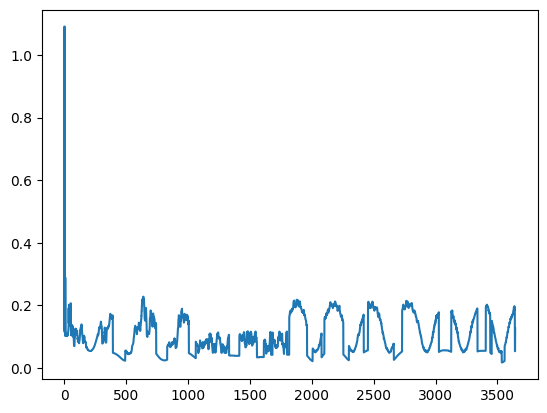

In [68]:
rng = jax.random.PRNGKey(20250901)
rngs = jax.random.split(rng, 10)

obs_dim = int(np.prod(all_imgs.shape[1:]))
model = MLP(
    layer_sizes = [obs_dim, 64, 64, 64, obs_dim],
    activation_cls = ReLU,
    key = rngs[0],
)

n_params = sum(x.size for x in jax.tree_util.tree_leaves(model))
print(f"Total parameters: {n_params:,}")

learning_rate = 1.0 / np.sqrt(np.prod(all_imgs.shape[1:]))
optimizer = optax.rmsprop(learning_rate=learning_rate)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))


### Prepare data ###

batch_size = 1
n_batches = (all_imgs.shape[0] - 1) // batch_size
n_samples = n_batches * batch_size

batched_inputs = all_imgs[:n_samples].reshape(n_batches, batch_size, -1)
batched_targets = all_imgs[1:n_samples+1].reshape(n_batches, batch_size, -1)


### Train ###

new_model, new_opt_state, stats = train_loop(
    model = model,
    optimizer = optimizer,
    opt_state = opt_state,
    inputs = batched_inputs,
    targets = batched_targets,
    rng = rngs[1],
)

print(stats['loss'].mean())
plt.plot(stats['loss'])

Total parameters: 354,975
0.029525962


(0.0, 1.0)

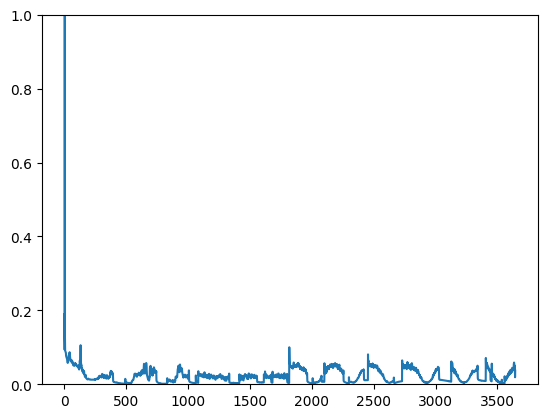

In [70]:
rng = jax.random.PRNGKey(20250901)
rngs = jax.random.split(rng, 10)

obs_dim = int(np.prod(all_imgs.shape[1:]))
conv_model = ConvAutoencoder(
    input_shape = all_imgs[0].transpose(2, 0, 1).shape,
    channel_sizes = (32, 16),
    kernel_sizes = (7, 4),
    strides = (4, 2),
    paddings = (0, 0),
    latent_dim = 128,
    first_decoder_padding = (0, 1),
    key = rngs[0],
)

n_params = sum(x.size for x in jax.tree_util.tree_leaves(conv_model) if isinstance(x, jnp.ndarray))
print(f"Total parameters: {n_params:,}")

learning_rate = 1.0 / np.sqrt(np.prod(all_imgs.shape[1:]))
optimizer = optax.rmsprop(learning_rate=learning_rate)
opt_state = optimizer.init(eqx.filter(conv_model, eqx.is_inexact_array))


### Prepare data ###

batch_size = 1
n_batches = (all_imgs.shape[0] - 1) // batch_size
n_samples = n_batches * batch_size

reshaped_imgs = all_imgs.transpose(0, 3, 1, 2)
batched_inputs = reshaped_imgs[:n_samples].reshape(n_batches, batch_size, *reshaped_imgs.shape[1:])
batched_targets = reshaped_imgs[1:n_samples+1].reshape(n_batches, batch_size, *reshaped_imgs.shape[1:])


### Train ###

new_conv_model, new_opt_state, stats = train_loop(
    model = conv_model,
    optimizer = optimizer,
    opt_state = opt_state,
    inputs = batched_inputs,
    targets = batched_targets,
    rng = rngs[1],
)

print(stats['loss'].mean())
plt.plot(stats['loss'])
plt.ylim(0, 1)


0.10060621


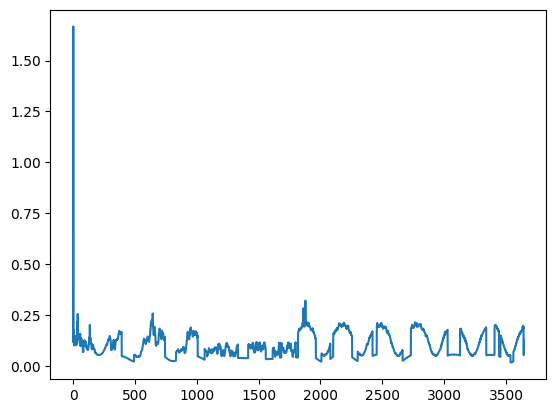

In [ ]:
batch_size = 1
n_batches = all_imgs.shape[0] // batch_size
n_samples = n_batches * batch_size

batched_inputs = all_imgs[:n_samples].reshape(n_batches, batch_size, -1)
batched_targets = all_imgs[:n_samples].reshape(n_batches, batch_size, -1)

new_model, new_opt_state, stats = train_loop(
    model = model,
    optimizer = optimizer,
    opt_state = opt_state,
    inputs = all_imgs,
    targets = all_imgs,
    batch_size = 1,
    rng = rngs[1],
)

print(stats['loss'].mean())
plt.plot(stats['loss'])

In [131]:
jax.tree.reduce(lambda x, y: x and y, jax.tree.map(lambda x, y: (x == y).all(), model, new_model))

Array(False, dtype=bool)